In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pulp import *

In [2]:
mp = pd.read_csv("monthly prices.csv",index_col=0)

In [3]:
mr = mp.pct_change().dropna()

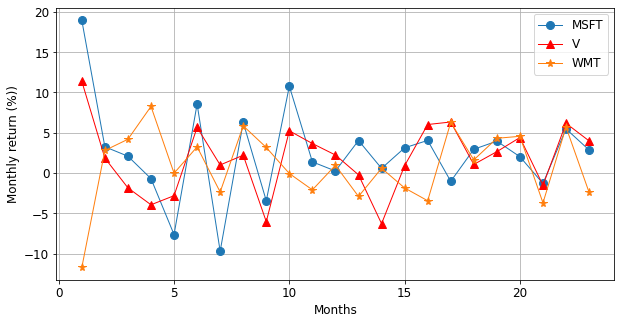

In [4]:
plt.figure(figsize=(10,5))
plt.plot([i for i in range(1,24)],100*mr['MSFT'],lw=1,marker='o',markersize=8)
plt.plot([i for i in range(1,24)],100*mr['V'],lw=1,c='red',marker='^',markersize=8)
plt.plot([i for i in range(1,24)],100*mr['WMT'],lw=1,marker='*',markersize=8)
plt.legend(mp.columns,fontsize=12)
plt.xlabel("Months",fontsize=12)
plt.ylabel("Monthly return (%))",fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.show()

In [5]:
return_data = mr.values.T

In [6]:
r = np.asarray(np.mean(return_data, axis=1))
C = np.asmatrix(np.cov(return_data))

In [7]:
symbols = mr.columns
risk = {}
returns = {}

In [8]:
for j in range(len(symbols)):
    print ('%s: Exp ret = %f, Risk = %f' %(symbols[j],r[j], C[j,j]**0.5))
    risk[symbols[j]] = round(C[j,j]**0.5,4)
    returns[symbols[j]] = round(r[j], 4)

MSFT: Exp ret = 0.024611, Risk = 0.058040
V: Exp ret = 0.018237, Risk = 0.042807
WMT: Exp ret = 0.009066, Risk = 0.044461


In [9]:
min_risk = LpProblem("Minimize_Risk",LpMinimize)
min_risk

Minimize_Risk:
MINIMIZE
None
VARIABLES

In [10]:
stock_vars = LpVariable.dicts("Stocks",symbols,0,cat='Continuous')

In [11]:
min_risk += lpSum([stock_vars[s]*risk[s] for s in symbols]) 

In [12]:
min_risk += lpSum([returns[s] * stock_vars[s] for s in symbols]) >=.02

In [13]:
min_risk += lpSum([stock_vars[s] for s in symbols]) == 1.0

In [14]:
min_risk

Minimize_Risk:
MINIMIZE
0.058*Stocks_MSFT + 0.0428*Stocks_V + 0.0445*Stocks_WMT + 0.0
SUBJECT TO
_C1: 0.0246 Stocks_MSFT + 0.0182 Stocks_V + 0.0091 Stocks_WMT >= 0.02

_C2: Stocks_MSFT + Stocks_V + Stocks_WMT = 1

VARIABLES
Stocks_MSFT Continuous
Stocks_V Continuous
Stocks_WMT Continuous

In [15]:
min_risk.solve()

1

In [16]:
print("Status:", LpStatus[min_risk.status])

Status: Optimal


In [17]:
stock_vars_inverse = {str(v): k for k, v in stock_vars.items()}
return_values = {}

for v in min_risk.variables():
#     if v.varValue>0:
    print(v.name, "=", round(v.varValue,2))
    return_values[stock_vars_inverse[v.name]] = v.varValue

Stocks_MSFT = 0.28
Stocks_V = 0.72
Stocks_WMT = 0.0


In [18]:
print("The expect risk is {}%".format(round(100*value(min_risk.objective),2)))

The expect risk is 4.71%


In [19]:
val = []

for i in symbols:
#     print(return_values[i],returns[i])
    val.append(return_values[i]*returns[i])
    
print('The return is', 100*sum(val), '%')

The return is 2.0 %
